In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import skimage.io as io
from skimage.transform import resize
import os

/home/simon/.conda/envs/tf1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/simon/.conda/envs/tf1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/simon/.conda/envs/tf1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/simon/.conda/envs/tf1.12/lib/python3.6/site-packages

# Data

In [5]:
POS_DIR = "/home/simon/Desktop/HealthHack/data/good_side/numpy/"
NEG_DIR = "/home/simon/Desktop/HealthHack/data/bad_side/numpy/"
POS_DIR_2 = "/home/simon/Desktop/HealthHack/data/good_top/numpy/"
BATCH_SIZE = 100
IMG_DIM = 28

In [19]:
from skimage import filters

from skimage.morphology import disk
from skimage.filters.rank import median


class DataGen(object):

    def __init__(self, img_dir, img_dim, batch_size, shuffle=True, rgb=True, labels=False):
        self.img_dir = img_dir
        self.img_dim = img_dim
        self.batch_size = batch_size
        self.files = np.array([os.path.join(self.img_dir, file) for file in os.listdir(self.img_dir)])
        self.n = len(self.files)
        self.indices = np.arange(0, self.n)
        self.rgb = rgb
        self.labels = labels
        if shuffle:
            np.random.shuffle(self.indices)
        self.pos = 0

    def _get_indices(self, i):
        return self.indices[i * self.batch_size:i * self.batch_size + self.batch_size]

    def __getitem__(self, i):
        batch1 = []
        batch2 = []
        labels = []
        files = self.files[self._get_indices(i)]
        for file in files:
            try:
                if self.rgb:
                    img = io.imread(file) #/ 255.
                
                else:
                    img = np.load(file)
                
                
                if len(img.shape) == 3:
                    img = img[0]
                
                
                img = filters.gaussian(img, sigma=3)
                
                if img.shape[0] != self.img_dim or img.shape[1] != self.img_dim:
                    img = resize(img, (self.img_dim, self.img_dim))
                    

                #img = median((img*255.).astype("uint8"), disk(2)) / 255.
                
                
                
                # Augment left to right
                if np.random.random() > 0.5:
                    img = np.fliplr(img)
                
                # Augment rot90
                turns = np.random.choice([0, 1, 2, 3], size=1)
                img = np.rot90(img, k=turns)
                
                batch1.append(img)
                
                # Add roberts
                img = filters.roberts(img)
                
                batch2.append(img)
                
                if self.labels:
                    label = float(file.split("/")[-1].split("_")[0])
                    labels.append(label)
                
            except Exception as e:
                print("Failed to load:", file, e)
                
                
        batch1 = np.expand_dims(np.stack(batch1), -1)
        batch2 = np.expand_dims(np.stack(batch2), -1)
        
        
        # Normalise
        mean = np.mean(batch1, axis=(1, 2, 3))
        std = np.std(batch1, axis=(1, 2, 3))
        batch1 = np.divide(np.subtract(batch1.T, mean), std).T
        
        # Normalise
        mean = np.mean(batch2, axis=(1, 2, 3))
        std = np.std(batch2, axis=(1, 2, 3))
        batch2 = np.divide(np.subtract(batch2.T, mean), std).T
        
        
        
        
#         # Mask
#         canvas = np.zeros((100, 28, 28, 1))
#         canvas[:, 7:22, 7:22, 0] = batch[:, 7:22, 7:22, 0]
        
        if self.labels:
            return [batch1, batch2], np.array(labels).reshape(self.batch_size, 1)

        return batch1

    def __next__(self):
        self.pos += 1
        if self.pos > self.n // self.batch_size:
            self.pos = 1
        return self.__getitem__(self.pos - 1)
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Stupid way to get file names...

In [20]:
pos_gen = DataGen(img_dir=POS_DIR, img_dim=IMG_DIM, batch_size=BATCH_SIZE, rgb=False, labels=True)
neg_gen = DataGen(img_dir=NEG_DIR, img_dim=IMG_DIM, batch_size=BATCH_SIZE, rgb=False, labels=True)
ext_gen = DataGen(img_dir=POS_DIR_2, img_dim=IMG_DIM, batch_size=BATCH_SIZE, rgb=False, labels=True)

In [21]:
pos_files = pos_gen.files
neg_files = neg_gen.files
ext_files = ext_gen.files

In [22]:
pos = int(len(pos_files) * 0.7); pos

698

In [23]:
train_pos = pos_files[:pos]
val_pos = pos_files[pos:]
train_neg = neg_files[:pos]
val_neg = neg_files[pos:]
train_ext = ext_files[:pos]
val_ext = ext_files[pos:]

In [24]:
train_files = np.concatenate([train_pos, train_neg, train_ext])
val_files = np.concatenate([val_pos, val_neg, val_ext])

Create new generators and then set files

In [25]:
train_gen = DataGen(img_dir=NEG_DIR, img_dim=IMG_DIM, batch_size=BATCH_SIZE, rgb=False, labels=True)
val_gen = DataGen(img_dir=NEG_DIR, img_dim=IMG_DIM, batch_size=BATCH_SIZE, rgb=False, labels=True)

In [26]:
train_gen.files = train_files
train_gen.n = len(train_files)
train_gen.indices = np.arange(train_gen.n)
np.random.shuffle(train_gen.indices)

In [27]:
val_gen.files = val_files
val_gen.n = len(val_files)
val_gen.indices = np.arange(val_gen.n)
np.random.shuffle(val_gen.indices)

In [28]:
train_gen.n, val_gen.n

(2094, 938)

In [29]:
X, y = train_gen[0]

In [32]:
#X.shape

In [31]:
y.shape

(100, 1)

# Classifier

In [33]:
keras.backend.clear_session()

model_input_1 = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(model_input_1)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.AveragePooling2D()(x)
feat1 = layers.Flatten()(x)
#x = layers.Dropout(0.8)(x)


model_input_2 = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(model_input_2)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.AveragePooling2D()(x)
feat2 = layers.Flatten()(x)
#x = layers.Dropout(0.8)(x)

x = layers.Concatenate()([feat1, feat2])

model_output = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model([model_input_1, model_input_2], [model_output], name="classifer")
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (

In [34]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
               loss="binary_crossentropy",
               metrics=["acc"])

In [35]:
history = model.fit_generator(generator=train_gen,
                    steps_per_epoch=train_gen.n // train_gen.batch_size,
                    epochs=120,
                    validation_data=val_gen,
                    validation_steps=val_gen.n//val_gen.batch_size
                   )

Epoch 1/120
20/20 [==============================] - 16s 791ms/step - loss: 0.6523 - acc: 0.6490 - val_loss: 0.6013 - val_acc: 0.7022
Epoch 2/120
20/20 [==============================] - 10s 522ms/step - loss: 0.6225 - acc: 0.6680 - val_loss: 0.5939 - val_acc: 0.7056
Epoch 3/120
20/20 [==============================] - 11s 543ms/step - loss: 0.6071 - acc: 0.6820 - val_loss: 0.5783 - val_acc: 0.7144
Epoch 4/120
20/20 [==============================] - 11s 540ms/step - loss: 0.5979 - acc: 0.6910 - val_loss: 0.5774 - val_acc: 0.7100
Epoch 5/120
20/20 [==============================] - 11s 532ms/step - loss: 0.5898 - acc: 0.6955 - val_loss: 0.5653 - val_acc: 0.7056
Epoch 6/120
20/20 [==============================] - 11s 553ms/step - loss: 0.5795 - acc: 0.7045 - val_loss: 0.5577 - val_acc: 0.7178
Epoch 7/120
20/20 [==============================] - 11s 531ms/step - loss: 0.5591 - acc: 0.7295 - val_loss: 0.5325 - val_acc: 0.7467
Epoch 8/120
20/20 [==============================] - 11s 558ms

In [36]:
model.save_weights("./roberts_original_top_val_acc_90.h5")

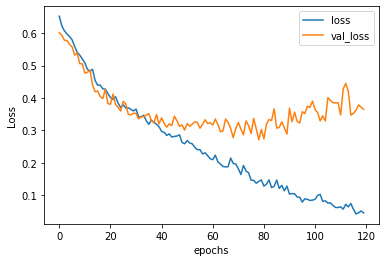

In [37]:
plt.plot(range(len(history.history["loss"])), history.history["loss"], label="loss")
plt.plot(range(len(history.history["loss"])), history.history["val_loss"], label="val_loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

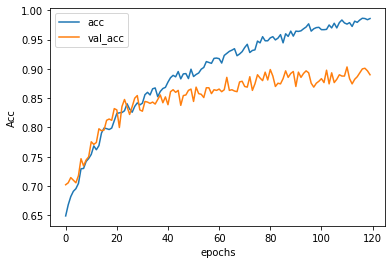

In [38]:
plt.plot(range(len(history.history["loss"])), history.history["acc"], label="acc")
plt.plot(range(len(history.history["loss"])), history.history["val_acc"], label="val_acc")
plt.xlabel("epochs")
plt.ylabel("Acc")
plt.legend()
plt.show()

# Metrics

In [39]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [40]:
y_val = []
X1_val = []
X2_val = []

val_gen.batch_size = 1

for i in range(val_gen.n):
    X, y = val_gen[i]
    
    y_val.append(y[0])
    X1_val.append(X[0][0])
    X2_val.append(X[1][0])

y_val = np.stack(y_val)
X1_val = np.stack(X1_val)
X2_val = np.stack(X2_val)

In [41]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(val_gen.n)]

# predict probabilities

lr_probs = model.predict([X1_val, X2_val], verbose=1)

938/938 [==============================] - 0s 166us/step


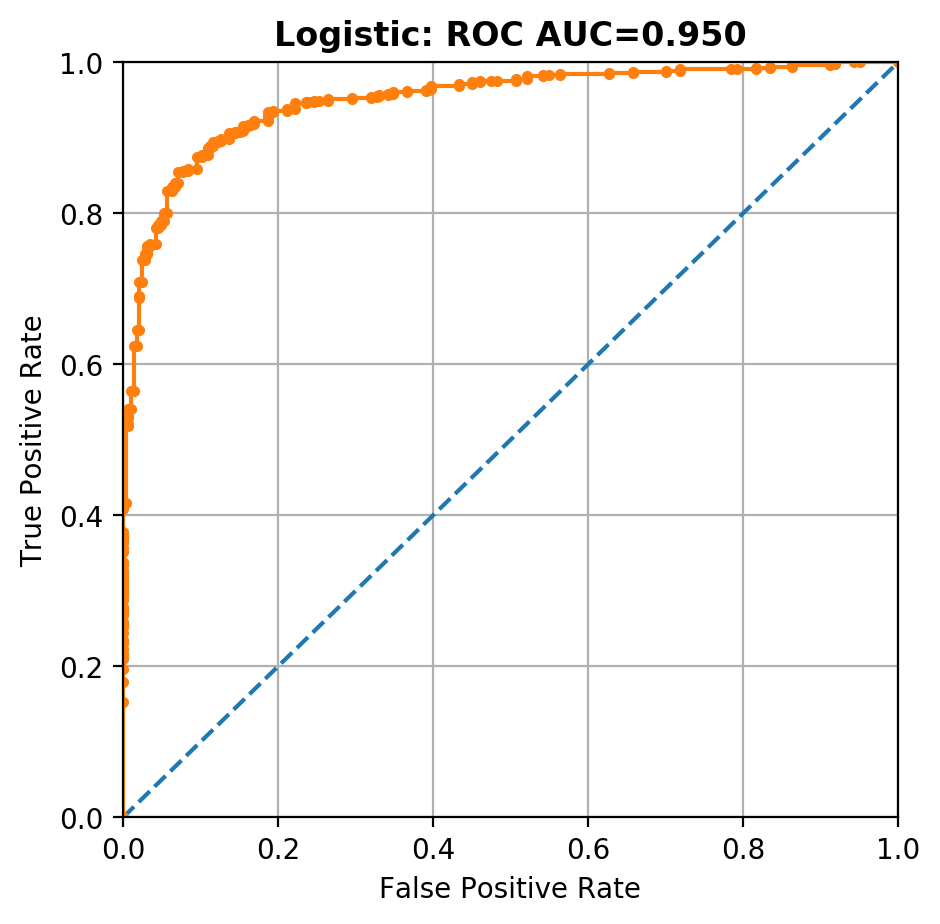

In [42]:
# calculate scores
ns_auc = roc_auc_score(y_val, ns_probs)
lr_auc = roc_auc_score(y_val, lr_probs)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_val, lr_probs)

# plot the roc curve for the model
plt.figure(figsize=(5,5), dpi= 200)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the plot
plt.title('Logistic: ROC AUC=%.3f' % (lr_auc), fontweight='bold')
plt.xlim([0,1])
plt.ylim([0,1])
plt.grid()
plt.show()

# Test-Time Augmentation

In [43]:
from skimage import filters

from skimage.morphology import disk
from skimage.filters.rank import median


class TestGen(object):

    def __init__(self, img_dir, img_dim, batch_size, shuffle=True, rgb=True, labels=False):
        self.img_dir = img_dir
        self.img_dim = img_dim
        self.batch_size = batch_size
        self.files = np.array([os.path.join(self.img_dir, file) for file in os.listdir(self.img_dir)])
        self.n = len(self.files)
        self.indices = np.arange(0, self.n)
        self.rgb = rgb
        self.labels = labels
        if shuffle:
            np.random.shuffle(self.indices)
        self.pos = 0

    def _get_indices(self, i):
        return self.indices[i * self.batch_size:i * self.batch_size + self.batch_size]

    def __getitem__(self, i):
        batch1 = []
        batch2 = []
        labels = []
        files = self.files[self._get_indices(i)]
        for file in files:
            try:
                if self.rgb:
                    img = io.imread(file) #/ 255.
                
                else:
                    img = np.load(file)
                
                
                if len(img.shape) == 3:
                    img = img[0]
                
                
                img = filters.gaussian(img, sigma=3)
                
                if img.shape[0] != self.img_dim or img.shape[1] != self.img_dim:
                    img = resize(img, (self.img_dim, self.img_dim))
                    

                #img = median((img*255.).astype("uint8"), disk(2)) / 255.
                
                
                # Augment left to right
                #if np.random.random() > 0.5:
                #    img = np.fliplr(img)
                
                # Augment rot90
                #turns = np.random.choice([0, 1, 2, 3], size=1)
                #img = np.rot90(img, k=turns)
                
                batch1.append(img)
                
                # Add roberts
                #img = filters.roberts(img)
                
                batch2.append(img)
                
                if self.labels:
                    label = float(file.split("/")[-1].split("_")[0])
                    labels.append(label)
                
            except Exception as e:
                print("Failed to load:", file, e)
                
                
        batch1 = np.expand_dims(np.stack(batch1), -1)
        batch2 = np.expand_dims(np.stack(batch2), -1)
        
        
        # Normalise
        mean = np.mean(batch1, axis=(1, 2, 3))
        std = np.std(batch1, axis=(1, 2, 3))
        batch1 = np.divide(np.subtract(batch1.T, mean), std).T
        
        # Normalise
        mean = np.mean(batch2, axis=(1, 2, 3))
        std = np.std(batch2, axis=(1, 2, 3))
        batch2 = np.divide(np.subtract(batch2.T, mean), std).T
        
        
        if self.labels:
            return [batch1, batch2], np.array(labels).reshape(self.batch_size, 1)

        return batch1

    def __next__(self):
        self.pos += 1
        if self.pos > self.n // self.batch_size:
            self.pos = 1
        return self.__getitem__(self.pos - 1)
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [44]:
tta_gen = DataGen(img_dir=NEG_DIR, img_dim=IMG_DIM, batch_size=BATCH_SIZE, rgb=False, labels=True)

In [45]:
tta_gen.files = val_files
tta_gen.n = len(val_files)
tta_gen.indices = np.arange(tta_gen.n)
np.random.shuffle(tta_gen.indices)

predictions...

In [56]:
y_val = []
X1_val = []
X2_val = []

tta_gen.batch_size = 1

for i in range(tta_gen.n):
    X, y = tta_gen[i]
    
    y_val.append(y[0])
    X1_val.append(X[0][0])
    X2_val.append(X[1][0])

y_val = np.stack(y_val)
X1_val = np.stack(X1_val)
X2_val = np.stack(X2_val)

In [57]:
y_val

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],

In [58]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(tta_gen.n)]

In [62]:
# predict probabilities
lr_probs = []

for i in range(tta_gen.n):
    
    group = []
    for j in range(2):
        
        if j == 0:
            x1 = X1_val[i]
            x2 = X2_val[i]
        
        if j == 1:
            x1 = np.fliplr(X1_val[i])
            x2 = np.fliplr(X2_val[i])
            
        
        
        for f in range(4):
        
            x1 = np.rot90(x1, f)
            x2 = np.rot90(x2, f)
    

            p = model.predict([np.expand_dims(x1, 0), np.expand_dims(x2, 0)], verbose=1).squeeze()
        
            group.append(p)
    
    print(group)
    
    lr_probs.append(np.mean(group))

1/1 [==============================] - 0s 2ms/step
[array(0.9992151, dtype=float32), array(0.966781, dtype=float32), array(0.99985063, dtype=float32), array(0.9965856, dtype=float32), array(0.98632497, dtype=float32), array(0.99914026, dtype=float32), array(0.9999989, dtype=float32), array(0.65993875, dtype=float32)]
1/1 [==============================] - 0s 2ms/step
[array(0.00499054, dtype=float32), array(0.00123095, dtype=float32), array(0.0093418, dtype=float32), array(0.00362252, dtype=float32), array(0.00238863, dtype=float32), array(0.13297789, dtype=float32), array(0.00854884, dtype=float32), array(0.00137925, dtype=float32)]
1/1 [==============================] - 0s 2ms/step
[array(0.00310392, dtype=float32), array(0.00063569, dtype=float32), array(0.3872949, dtype=float32), array(0.00615223, dtype=float32), array(0.009903, dtype=float32), array(0.05766405, dtype=float32), array(0.11996607, dtype=float32), array(0.00574808, dtype=float32)]
1/1 [==============================] 

In [63]:
len(lr_probs)

938

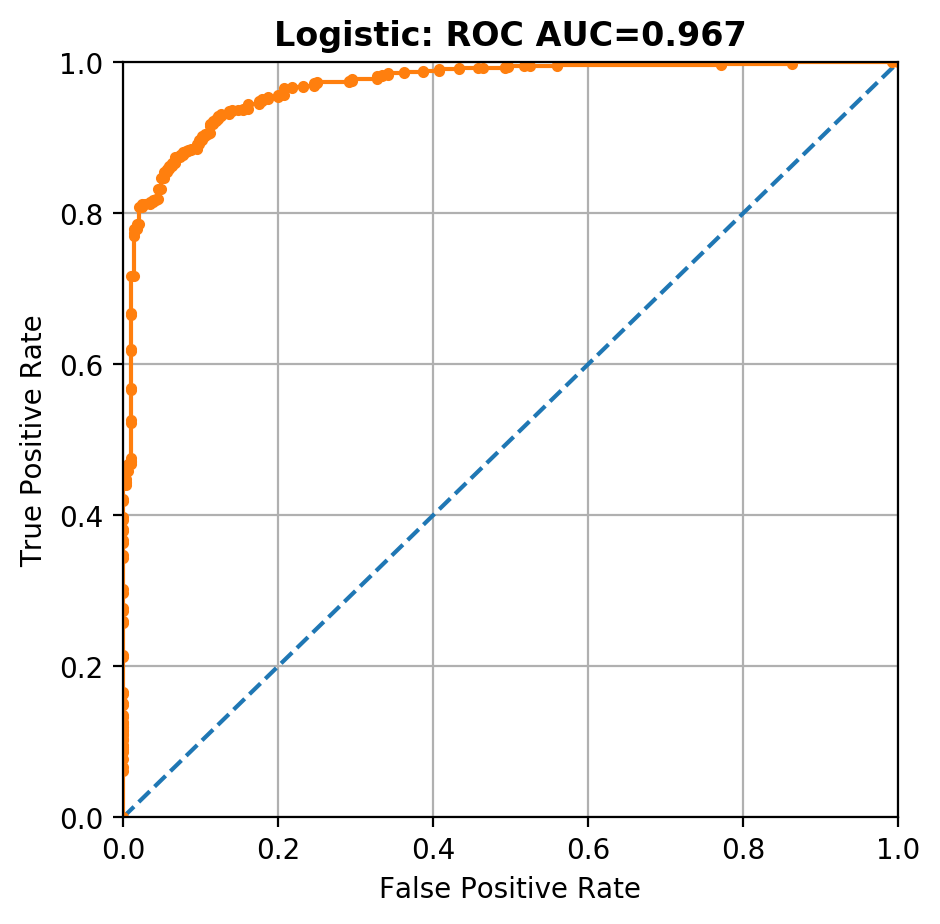

In [64]:
# calculate scores
ns_auc = roc_auc_score(y_val, ns_probs)
lr_auc = roc_auc_score(y_val, lr_probs)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_val, lr_probs)

# plot the roc curve for the model
plt.figure(figsize=(5,5), dpi= 200)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the plot
plt.title('Logistic: ROC AUC=%.3f' % (lr_auc), fontweight='bold')
plt.xlim([0,1])
plt.ylim([0,1])
plt.grid()
plt.show()

# Confusion Matrix

In [65]:
model.load_weights("./weights/roberts_original_top_val_acc_90.h5")

In [125]:
lr_pred = [ (prob > 0.6).astype("float") for prob in lr_probs]

In [126]:
cm = np.zeros((2, 2))

for t, p in zip(y_val, lr_pred):
    cm[int(t[0]),int(p)] += 1
    
    
normed = np.copy(cm)
normed[0] /= normed.sum(axis=1)[0]
normed[1] /= normed.sum(axis=1)[1]

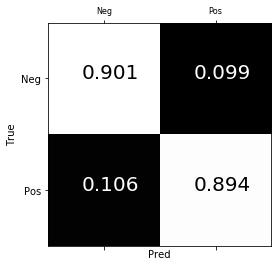

In [127]:
plt.matshow(normed, cmap="gray")


plt.xticks([0,1], labels=["Neg", "Pos"], size=8)
plt.yticks([0,1], labels=["Neg", "Pos"])

plt.xlabel("Pred")
plt.ylabel("True")

plt.text(0-0.2, 0, normed[0, 0].round(3), c="black", size=20)
plt.text(1-0.2, 0, normed[0, 1].round(3), c="white", size=20)
plt.text(1-0.2, 1, normed[1, 1].round(3), c="black", size=20)
plt.text(0-0.2, 1, normed[1, 0].round(3), c="white", size=20)


plt.show()

# EXTERNAL POSITIVE

In [143]:
IMG_DIR = "/home/simon/Desktop/HealthHack/data/good_top/numpy"
tta_gen = DataGen(img_dir=IMG_DIR, img_dim=IMG_DIM, batch_size=BATCH_SIZE, rgb=False, labels=True)

In [144]:
tta_gen.files

array(['/home/simon/Desktop/HealthHack/data/good_top/numpy/1_mrcs_0680.npy',
       '/home/simon/Desktop/HealthHack/data/good_top/numpy/1_mrcs_0476.npy',
       '/home/simon/Desktop/HealthHack/data/good_top/numpy/1_mrcs_0231.npy',
       ...,
       '/home/simon/Desktop/HealthHack/data/good_top/numpy/1_mrcs_0035.npy',
       '/home/simon/Desktop/HealthHack/data/good_top/numpy/1_mrcs_0827.npy',
       '/home/simon/Desktop/HealthHack/data/good_top/numpy/1_mrcs_0492.npy'],
      dtype='<U66')

In [145]:
y_val = []
X1_val = []
X2_val = []

tta_gen.batch_size = 1

for i in range(tta_gen.n):
    X, y = tta_gen[i]
    
    y_val.append(y[0])
    X1_val.append(X[0][0])
    X2_val.append(X[1][0])

y_val = np.stack(y_val)
X1_val = np.stack(X1_val)
X2_val = np.stack(X2_val)

In [146]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(tta_gen.n)]

In [147]:
# predict probabilities
lr_probs = []

for i in range(584):
    
    group = []
    for j in range(2):
        
        if j == 0:
            x1 = X1_val[i]
            x2 = X2_val[i]
        
        if j == 1:
            x1 = np.fliplr(X1_val[i])
            x2 = np.fliplr(X2_val[i])
            
        
        
        for f in range(4):
        
            x1 = np.rot90(x1, f)
            x2 = np.rot90(x2, f)
    

            p = model.predict([np.expand_dims(x1, 0), np.expand_dims(x2, 0)], verbose=1).squeeze()
        
            group.append(p)
    
    print(group)
    
    lr_probs.append(max(group))

1/1 [==============================] - 0s 4ms/step
[array(3.044615e-08, dtype=float32), array(3.9231595e-06, dtype=float32), array(4.858861e-09, dtype=float32), array(4.6391824e-06, dtype=float32), array(2.9045768e-06, dtype=float32), array(5.8339344e-07, dtype=float32), array(0.00014193, dtype=float32), array(5.739703e-08, dtype=float32)]
1/1 [==============================] - 0s 2ms/step
[array(0.00545656, dtype=float32), array(0.01137549, dtype=float32), array(0.01016035, dtype=float32), array(0.00050961, dtype=float32), array(4.4202847e-05, dtype=float32), array(0.01388655, dtype=float32), array(0.00889393, dtype=float32), array(0.00228159, dtype=float32)]
1/1 [==============================] - 0s 1ms/step
[array(0.00763961, dtype=float32), array(1.0396792e-05, dtype=float32), array(0.00426028, dtype=float32), array(0.00201219, dtype=float32), array(1.0356565e-05, dtype=float32), array(0.21946175, dtype=float32), array(0.00030484, dtype=float32), array(0.00050493, dtype=float32)]
1

In [148]:
lr_pred = [ (prob > 0.99).astype("float") for prob in lr_probs]

In [149]:
cm = np.zeros((2, 2))

for t, p in zip(y_val, lr_pred):
    cm[int(t[0]),int(p)] += 1
    
    
normed = cm / cm.sum(axis=1)


/home/simon/.conda/envs/tf1.12/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/home/simon/.conda/envs/tf1.12/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


/home/simon/.conda/envs/tf1.12/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/simon/.conda/envs/tf1.12/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


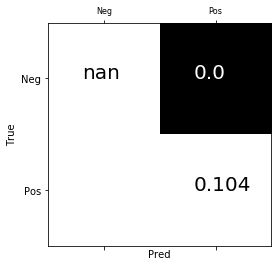

In [150]:
plt.matshow(cm / cm.sum(axis=1), cmap="gray")

plt.xticks([0,1], labels=["Neg", "Pos"], size=8)
plt.yticks([0,1], labels=["Neg", "Pos"])


plt.xlabel("Pred")
plt.ylabel("True")

plt.text(0-0.2, 0, normed[0, 0].round(3), c="black", size=20)
plt.text(1-0.2, 0, normed[0, 1].round(3), c="white", size=20)
plt.text(0-0.2, 1, normed[1, 0].round(3), c="white", size=20)
plt.text(1-0.2, 1, normed[1, 1].round(3), c="black", size=20)

plt.show()

In [151]:
cm

array([[  0.,   0.],
       [523.,  61.]])